# KADEM Hocine
# BENAHMED Neil

 Copyright © Sorbonne University.

 This source code is licensed under the MIT license found in the
 LICENSE file in the root directory of this source tree.

In [103]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
# Installs the necessary Python and system libraries
try:
    from easypip import easyimport, easyinstall, is_notebook
except ModuleNotFoundError as e:
    get_ipython().run_line_magic("pip", "install 'easypip>=1.2.0'")
    from easypip import easyimport, easyinstall, is_notebook

easyinstall("swig")
easyinstall("bbrl>=0.2.2")
easyinstall("bbrl_gymnasium>=0.2.0")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")
easyinstall("optuna")
easyinstall("gymnasium")
easyinstall("mazemdp")

import numpy as np
import os
from typing import List

import hydra
import optuna
import yaml
from omegaconf import OmegaConf, DictConfig

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

from IPython.display import Video
import torch.nn as nn
import gymnasium as gym
from bbrl.utils.chrono import Chrono
import matplotlib
import matplotlib.pyplot as plt
from mazemdp.toolbox import sample_categorical
from mazemdp.mdp import Mdp
from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder
from functools import partial
import tools 
matplotlib.use("TkAgg")
import gymnasium as gym
import tools
from scipy.stats import ttest_ind

# Environment with 20% of walls and no negative reward when hitting a wall
env = gym.make(
    "MazeMDP-v0",
    kwargs={"width": 4, "height": 3, "ratio": 0.2, "hit": 0.0},
    render_mode="human",
)

# Naive actor critic algorithm Function

In [105]:
def naive_actor_critic(
    env: MazeMDPEnv,
    alpha_actor: float,
    alpha_critic: float,
    gamma: float,
    nb_episodes: int = 1000,
    timeout: int = 50,
    render: bool = False,
):
    """
    Naive actor-critic algorithm with entropy and convergence tracking.
    Args:
        env: The environment
        alpha_actor: Learning rate for the actor
        alpha_critic: Learning rate for the critic
        gamma: Discount factor
        nb_episodes: Number of episodes
        timeout: Maximum number of steps per episode
        render: Boolean flag to render the environment
    Returns:
        policy, value_function, trajectories, entropies, convergence_steps
    """
    V = np.zeros(env.nb_states)  # Critic (value function V(s))
    pi = np.ones((env.nb_states, env.action_space.n)) / env.action_space.n  # Actor (policy pi(a|s))

    def renormalize_policy(pi, s):
        pi[s, :] = pi[s, :] / np.sum(pi[s, :])

    trajectories = []
    entropies = []  # List to track entropy
    convergence_steps = 0

    for episode in range(nb_episodes):
        s, _ = env.reset(uniform=True)
        cpt = 0
        terminated = False
        truncated = False
        entropy_episode = 0

        while not (terminated or truncated) and cpt < timeout:
            if render:
                env.draw_v_pi(V, pi.argmax(axis=1))

            a = sample_categorical(pi[s, :])
            s_next, r, terminated, truncated, _ = env.step(a)
            delta = r + gamma * V[s_next] * (1 - terminated) - V[s]
            V[s] = V[s] + alpha_critic * delta

            pi_temp = pi[s, a] + alpha_actor * delta
            pi_temp = max(pi_temp, 1e-8)
            pi[s, a] = pi_temp
            renormalize_policy(pi, s)

            # Calculate entropy for current state
            entropy_episode += -np.sum(pi[s, :] * np.log(pi[s, :] + 1e-8))

            s = s_next
            cpt += 1

        trajectories.append(cpt)
        entropies.append(entropy_episode)  # Store entropy for this episode

        # Check for convergence (e.g., policy does not change significantly)
        if episode > 1 and np.allclose(pi, previous_pi, atol=1e-3):
            convergence_steps = episode
            break

        previous_pi = pi.copy()

    return pi, V, trajectories, entropies, convergence_steps


### Actor-critic hyper-parameters

In [106]:
# Define global constants 
NB_EPISODES = 400

AC_PARAMS = {
    "save_curves": False,
    "save_heatmap": True,
    "mdp": {
        "name": "MazeMDP-v0",
        "width": 5,
        "height": 5,
        "ratio": 0.2,
        "render_mode": "human",  # "human" to render the maze OR "rgb_array"
    },
    "log_dir": "./tmp",
    "video_dir": "./tmp/videos",
    "nb_episodes": NB_EPISODES,
    "timeout": 200,
    "render": True,
    "nb_repeats": 5,
    "gamma": 0.5,
    
    "alpha_critic": 0.5,
    "alpha_actor": 0.5,
    }

# # Base actor-critic parameters
# AC_PARAMS = {
#     'nb_episodes': NB_EPISODES,
#     'timeout': 50,
#     'gamma': 0.99,
#     'mdp': {
#         'width': 5,
#         'height': 5,
#         'ratio': 0.2,
#         'render_mode': "humain",
#     },
#     "alpha_critic": 0.5,
#     "alpha_actor": 0.5,
# }

### Run multiple experiments

In [107]:
AC_PARAMS['mdp']['render_mode'] = "human"
env = tools.create_maze_from_params(AC_PARAMS)

alpha_actor = AC_PARAMS['alpha_actor']
alpha_critic = AC_PARAMS['alpha_critic']
gamma = AC_PARAMS['alpha_critic'] 
nb_episodes = AC_PARAMS['nb_episodes']
timeout = AC_PARAMS['timeout']
 

pi, V_per_episode, trajectories, entropies, rewards_per_episode, deltas = tools.naive_actor_critic(
            env, alpha_actor, alpha_critic, gamma, nb_episodes, timeout, render=True
        )

       [ 0, -1,  8, -1, 16],
       [ 1, -1,  9, …

In [108]:
%matplotlib inline
AC_PARAMS['mdp']["render_mode"] = "rgb_array"
n_runs = 5
# Run multiple experiments and gather results
all_values, all_trajectories, all_entropies, all_rewards, all_deltas = tools.run_multiple_experiments(env, alpha_actor, alpha_critic, gamma, nb_episodes, timeout, n_runs)

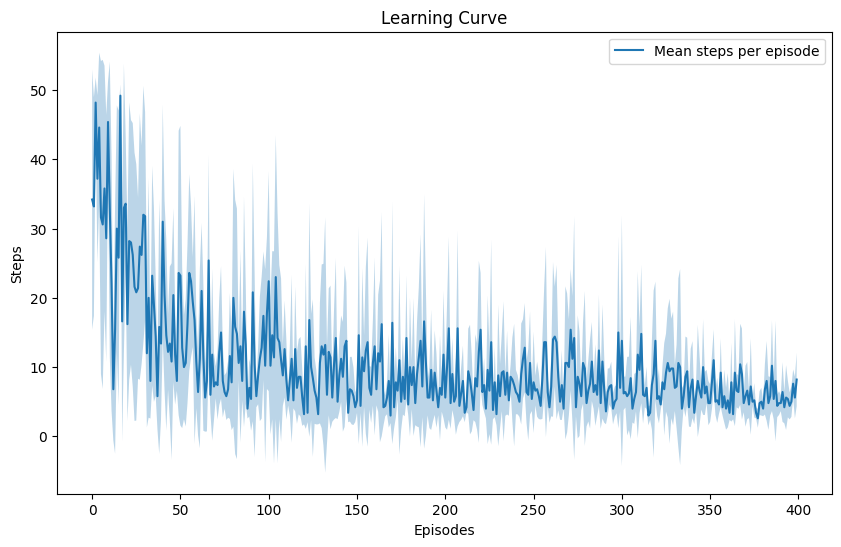

In [109]:
def plot_learning_curve(all_trajectories, plot_name=''):
    # Calculate mean and std for trajectories, assuming they are of different lengths
    max_len = max(map(len, all_trajectories))
    
    # Convert trajectories to arrays of floats and pad with NaN
    padded_trajectories = np.array([np.pad(np.array(t, dtype=float), (0, max_len - len(t)), 'constant', constant_values=np.nan) for t in all_trajectories])
    
    # Calculate mean and std, ignoring NaNs
    mean_trajectories = np.nanmean(padded_trajectories, axis=0)
    std_trajectories = np.nanstd(padded_trajectories, axis=0)
    
    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(mean_trajectories, label='Mean steps per episode')
    plt.fill_between(range(len(mean_trajectories)), mean_trajectories - std_trajectories, mean_trajectories + std_trajectories, alpha=0.3)
    plt.xlabel('Episodes')
    plt.ylabel('Steps')
    plt.title(plot_name)
    plt.legend()
    plt.show()

# Plot the learning curve with the updated function
plot_learning_curve(all_trajectories,'Learning Curve')

# Perform hyper-parameters tuning

## Set up the basic parameters and optimization criteria

In this first step, we define the base parameters for the optimization process, such as the search space for alpha_actor and alpha_critic, the samplers (search strategies), and store the optimization results.

In [110]:
# Total number of trials and the number of values for each hyperparameter
n_trials = 400  # Chosen for sufficient exploration of the search space

# The number of independent runs per trial to average results and reduce variability.
n_runs = 3  # Ensures stability of results across multiple runs

# The number of episodes per trial
nb_episodes = 200  # Chosen for enough training time per trial

In [111]:
from optuna.samplers import TPESampler, RandomSampler, NSGAIISampler, GridSampler

n_values = int(np.sqrt(n_trials))  # Ensure that the number of values matches the total number of trials

# Search space for alpha_actor and alpha_critic (logarithmic scale)
SEARCH_SPACE = {
    "alpha_actor": np.logspace(-3, 0, n_values).tolist(),  # From 1e-3 to 1.0 with n_values points
    "alpha_critic": np.logspace(-3, 0, n_values).tolist()  # Same range for alpha_critic
}

# List of samplers to evaluate
SAMPLERS = {
    "Grid Search": GridSampler(SEARCH_SPACE),
    "Random Search": RandomSampler(),
    "TPE (Bayesian Optimization)": TPESampler(),
    "NSGA-II": NSGAIISampler()
}

# Dictionary to store the results
results = {}

# Base actor-critic parameters
AC_PARAMS = {
    'nb_episodes': nb_episodes,
    'timeout': 50,
    'gamma': 0.8,
    'mdp': {
        'width': 5,
        'height': 5,
        'ratio': 0.2,
        'render_mode': None
    }
}

## Define the optimization loop for each criterion

In [113]:
# Define the optimization criteria
criteria = ['value_norm', 'convergence_time', 'cumulative_reward', 'discounted_cumulative_reward', 'temporal_difference_error']  

# Loop through each criterion
for criterion in criteria:
    print(f"Optimizing for criterion: {criterion}...")

    # For each criterion, we will loop through the samplers
    for sampler_name, sampler in SAMPLERS.items():
        print(f"Running optimization with {sampler_name}...")

        # Run optimization using the current criterion
        study, best_params, best_performance, all_params, value_norms, trajectories, cumulative_rewards, deltas = tools.run_optimization(
            ac_params=AC_PARAMS,
            sampler=sampler,
            n_trials=n_trials,  
            n_runs=n_runs, 
            criterion=criterion  # Optimization based on the selected criterion
        )

        # Store the results for each sampler
        results[f"{criterion}_{sampler_name}"] = {
            "study": study,
            "best_params": best_params,
            "best_performance": best_performance,
            "all_params": all_params,
            "value_norms": value_norms,
            "trajectories": trajectories,
            "cumulative_rewards": cumulative_rewards,
            "temporal_difference_error" : deltas
        }

        print(f"Best performance for {criterion} using {sampler_name}: {best_performance}")

[I 2024-10-04 18:05:24,889] A new study created in memory with name: no-name-34dc07b4-af6c-4141-b0d3-0c66a14a1259


Optimizing for criterion: value_norm...
Running optimization with Grid Search...
Sampler is GridSampler


/home/neil/dac/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.nb_states to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.nb_states` for environment variables or `env.get_wrapper_attr('nb_states')` that will search the reminding wrappers.
  logger.warn(
[I 2024-10-04 18:05:25,282] Trial 0 finished with value: -3.330571319072626 and parameters: {'alpha_actor': 0.008858667904100823, 'alpha_critic': 0.07847599703514611}. Best is trial 0 with value: -3.330571319072626.
[I 2024-10-04 18:05:25,555] Trial 1 finished with value: -3.5792234461949555 and parameters: {'alpha_actor': 0.23357214690901212, 'alpha_critic': 0.026366508987303583}. Best is trial 1 with value: -3.5792234461949555.
[I 2024-10-04 18:05:25,886] Trial 2 finished with value: -0.41105527016990173 and parameters: {'alpha_actor': 0.4832930238571752, 'alpha_critic': 0.0014384498882876629}. Best is trial 1 with value: -3.579223

Best performance for value_norm using Grid Search: -7.189962191892088
Running optimization with Random Search...
Sampler is RandomSampler


[I 2024-10-04 18:07:31,760] Trial 0 finished with value: -3.945187050687521 and parameters: {'alpha_actor': 0.2274427656988649, 'alpha_critic': 0.02553443345071098}. Best is trial 0 with value: -3.945187050687521.
[I 2024-10-04 18:07:32,100] Trial 1 finished with value: -0.7999729821879632 and parameters: {'alpha_actor': 0.4301729653124633, 'alpha_critic': 0.003345134420243443}. Best is trial 0 with value: -3.945187050687521.
[I 2024-10-04 18:07:32,442] Trial 2 finished with value: -2.0708399644913085 and parameters: {'alpha_actor': 0.019330446096151206, 'alpha_critic': 0.012848981083802035}. Best is trial 0 with value: -3.945187050687521.
[I 2024-10-04 18:07:32,857] Trial 3 finished with value: -0.07908330000040455 and parameters: {'alpha_actor': 2.7810682531557375e-05, 'alpha_critic': 0.0005341581895815132}. Best is trial 0 with value: -3.945187050687521.
[I 2024-10-04 18:07:33,169] Trial 4 finished with value: -3.386495200872458 and parameters: {'alpha_actor': 0.00016511182875005994

Best performance for value_norm using Random Search: -6.755040977545675
Running optimization with TPE (Bayesian Optimization)...
Sampler is TPESampler


[I 2024-10-04 18:09:49,262] Trial 0 finished with value: -4.775598588004627 and parameters: {'alpha_actor': 0.005167210374332946, 'alpha_critic': 0.8521214291816251}. Best is trial 0 with value: -4.775598588004627.
[I 2024-10-04 18:09:49,627] Trial 1 finished with value: -0.018832327121925257 and parameters: {'alpha_actor': 0.15293314027281218, 'alpha_critic': 8.952996150390464e-05}. Best is trial 0 with value: -4.775598588004627.
[I 2024-10-04 18:09:50,017] Trial 2 finished with value: -0.2411347875840858 and parameters: {'alpha_actor': 0.037507833125056705, 'alpha_critic': 0.0012432867664299847}. Best is trial 0 with value: -4.775598588004627.
[I 2024-10-04 18:09:50,340] Trial 3 finished with value: -1.592284478639208 and parameters: {'alpha_actor': 1.0218204376129531e-05, 'alpha_critic': 0.007260714253901527}. Best is trial 0 with value: -4.775598588004627.
[I 2024-10-04 18:09:50,625] Trial 4 finished with value: -5.143335182609581 and parameters: {'alpha_actor': 0.03147811271297298

Best performance for value_norm using TPE (Bayesian Optimization): -7.353941728229843
Running optimization with NSGA-II...
Sampler is NSGAIISampler


[I 2024-10-04 18:10:54,561] Trial 0 finished with value: -0.9539811057525442 and parameters: {'alpha_actor': 0.00018201772643416068, 'alpha_critic': 0.003785436701074073}. Best is trial 0 with value: -0.9539811057525442.
[I 2024-10-04 18:10:54,931] Trial 1 finished with value: -0.011523905454791292 and parameters: {'alpha_actor': 1.0298012531816749e-05, 'alpha_critic': 5.632136734887938e-05}. Best is trial 0 with value: -0.9539811057525442.
[I 2024-10-04 18:10:55,289] Trial 2 finished with value: -0.00909231106190265 and parameters: {'alpha_actor': 0.22835904346107788, 'alpha_critic': 3.6134883578057064e-05}. Best is trial 0 with value: -0.9539811057525442.
[I 2024-10-04 18:10:55,578] Trial 3 finished with value: -4.096384288582259 and parameters: {'alpha_actor': 0.008038667160044005, 'alpha_critic': 0.2738125809919753}. Best is trial 3 with value: -4.096384288582259.
[I 2024-10-04 18:10:55,968] Trial 4 finished with value: -0.5497444759906127 and parameters: {'alpha_actor': 0.00018781

Best performance for value_norm using NSGA-II: -7.177614072246521
Optimizing for criterion: convergence_time...
Running optimization with Grid Search...
Sampler is GridSampler


[I 2024-10-04 18:12:51,651] Trial 0 finished with value: 33.873333333333335 and parameters: {'alpha_actor': 0.008858667904100823, 'alpha_critic': 0.07847599703514611}. Best is trial 0 with value: 33.873333333333335.
[I 2024-10-04 18:12:51,925] Trial 1 finished with value: 28.148333333333333 and parameters: {'alpha_actor': 0.23357214690901212, 'alpha_critic': 0.026366508987303583}. Best is trial 1 with value: 28.148333333333333.
[I 2024-10-04 18:12:52,283] Trial 2 finished with value: 37.58166666666667 and parameters: {'alpha_actor': 0.4832930238571752, 'alpha_critic': 0.0014384498882876629}. Best is trial 1 with value: 28.148333333333333.
[I 2024-10-04 18:12:52,507] Trial 3 finished with value: 23.061666666666664 and parameters: {'alpha_actor': 0.026366508987303583, 'alpha_critic': 0.3359818286283781}. Best is trial 3 with value: 23.061666666666664.
[I 2024-10-04 18:12:52,887] Trial 4 finished with value: 39.51166666666667 and parameters: {'alpha_actor': 0.07847599703514611, 'alpha_cri

Best performance for convergence_time using Grid Search: 7.341666666666666
Running optimization with Random Search...
Sampler is RandomSampler


[I 2024-10-04 18:14:53,799] Trial 1 finished with value: 32.77333333333333 and parameters: {'alpha_actor': 3.7130525767917706e-05, 'alpha_critic': 0.011740909780120145}. Best is trial 0 with value: 9.845.
[I 2024-10-04 18:14:54,176] Trial 2 finished with value: 39.55833333333333 and parameters: {'alpha_actor': 1.0419082460674202e-05, 'alpha_critic': 0.0005082911173206971}. Best is trial 0 with value: 9.845.
[I 2024-10-04 18:14:54,412] Trial 3 finished with value: 23.925 and parameters: {'alpha_actor': 0.05010243094446163, 'alpha_critic': 0.9182387042311477}. Best is trial 0 with value: 9.845.
[I 2024-10-04 18:14:54,741] Trial 4 finished with value: 33.985 and parameters: {'alpha_actor': 6.841040453413638e-05, 'alpha_critic': 7.476877225806567e-05}. Best is trial 0 with value: 9.845.
[I 2024-10-04 18:14:55,053] Trial 5 finished with value: 32.12166666666667 and parameters: {'alpha_actor': 0.5292224313809214, 'alpha_critic': 0.0005059558007446121}. Best is trial 0 with value: 9.845.
[I 2

Best performance for convergence_time using Random Search: 8.506666666666666
Running optimization with TPE (Bayesian Optimization)...
Sampler is TPESampler


[I 2024-10-04 18:17:03,008] Trial 0 finished with value: 35.36666666666667 and parameters: {'alpha_actor': 0.0001591614691893527, 'alpha_critic': 0.0005578165668539634}. Best is trial 0 with value: 35.36666666666667.
[I 2024-10-04 18:17:03,340] Trial 1 finished with value: 33.8 and parameters: {'alpha_actor': 0.015477331787027216, 'alpha_critic': 9.046989096087313e-05}. Best is trial 1 with value: 33.8.
[I 2024-10-04 18:17:03,655] Trial 2 finished with value: 33.14333333333333 and parameters: {'alpha_actor': 0.06629353002905494, 'alpha_critic': 0.0011861338033943385}. Best is trial 2 with value: 33.14333333333333.
[I 2024-10-04 18:17:03,937] Trial 3 finished with value: 29.385 and parameters: {'alpha_actor': 0.014818588229236805, 'alpha_critic': 0.4919129575961171}. Best is trial 3 with value: 29.385.
[I 2024-10-04 18:17:04,217] Trial 4 finished with value: 29.236666666666668 and parameters: {'alpha_actor': 0.7521197831184917, 'alpha_critic': 0.004442218216918882}. Best is trial 4 with

Best performance for convergence_time using TPE (Bayesian Optimization): 6.251666666666668
Running optimization with NSGA-II...
Sampler is NSGAIISampler


[I 2024-10-04 18:18:06,461] Trial 0 finished with value: 33.89 and parameters: {'alpha_actor': 0.08633609568634866, 'alpha_critic': 0.0003407583644158138}. Best is trial 0 with value: 33.89.
[I 2024-10-04 18:18:06,672] Trial 1 finished with value: 21.075 and parameters: {'alpha_actor': 0.12382681173128401, 'alpha_critic': 0.09242846816089069}. Best is trial 1 with value: 21.075.
[I 2024-10-04 18:18:06,805] Trial 2 finished with value: 12.1 and parameters: {'alpha_actor': 0.7701257228701969, 'alpha_critic': 0.14171033447751186}. Best is trial 2 with value: 12.1.
[I 2024-10-04 18:18:07,144] Trial 3 finished with value: 35.62166666666667 and parameters: {'alpha_actor': 0.009920933369238433, 'alpha_critic': 0.00019705697454617684}. Best is trial 2 with value: 12.1.
[I 2024-10-04 18:18:07,525] Trial 4 finished with value: 39.78833333333333 and parameters: {'alpha_actor': 1.631265027950893e-05, 'alpha_critic': 0.16913913538629308}. Best is trial 2 with value: 12.1.
[I 2024-10-04 18:18:07,907

Best performance for convergence_time using NSGA-II: 6.469999999999999
Optimizing for criterion: cumulative_reward...
Running optimization with Grid Search...
Sampler is GridSampler


[I 2024-10-04 18:20:02,667] Trial 0 finished with value: -111.33333333333333 and parameters: {'alpha_actor': 0.008858667904100823, 'alpha_critic': 0.07847599703514611}. Best is trial 0 with value: -111.33333333333333.
[I 2024-10-04 18:20:02,910] Trial 1 finished with value: -146.0 and parameters: {'alpha_actor': 0.23357214690901212, 'alpha_critic': 0.026366508987303583}. Best is trial 1 with value: -146.0.
[I 2024-10-04 18:20:03,242] Trial 2 finished with value: -92.0 and parameters: {'alpha_actor': 0.4832930238571752, 'alpha_critic': 0.0014384498882876629}. Best is trial 1 with value: -146.0.
[I 2024-10-04 18:20:03,508] Trial 3 finished with value: -141.33333333333334 and parameters: {'alpha_actor': 0.026366508987303583, 'alpha_critic': 0.3359818286283781}. Best is trial 1 with value: -146.0.
[I 2024-10-04 18:20:03,885] Trial 4 finished with value: -53.666666666666664 and parameters: {'alpha_actor': 0.07847599703514611, 'alpha_critic': 0.008858667904100823}. Best is trial 1 with value

Best performance for cumulative_reward using Grid Search: -195.66666666666666
Running optimization with Random Search...
Sampler is RandomSampler


[I 2024-10-04 18:22:04,795] Trial 0 finished with value: -104.33333333333333 and parameters: {'alpha_actor': 0.00017626602308277984, 'alpha_critic': 3.511188146787714e-05}. Best is trial 0 with value: -104.33333333333333.
[I 2024-10-04 18:22:05,131] Trial 1 finished with value: -93.66666666666667 and parameters: {'alpha_actor': 0.07415693524294742, 'alpha_critic': 0.002159307101655082}. Best is trial 0 with value: -104.33333333333333.
[I 2024-10-04 18:22:05,467] Trial 2 finished with value: -86.33333333333333 and parameters: {'alpha_actor': 0.009502599881617505, 'alpha_critic': 0.07434688805580117}. Best is trial 0 with value: -104.33333333333333.
[I 2024-10-04 18:22:05,801] Trial 3 finished with value: -84.66666666666667 and parameters: {'alpha_actor': 0.17695197335526439, 'alpha_critic': 4.4556239415273215e-05}. Best is trial 0 with value: -104.33333333333333.
[I 2024-10-04 18:22:06,109] Trial 4 finished with value: -110.66666666666667 and parameters: {'alpha_actor': 0.00030140737175

Best performance for cumulative_reward using Random Search: -186.33333333333334
Running optimization with TPE (Bayesian Optimization)...
Sampler is TPESampler


[I 2024-10-04 18:24:21,588] Trial 0 finished with value: -95.33333333333333 and parameters: {'alpha_actor': 0.4891779382205555, 'alpha_critic': 0.00032613059851454977}. Best is trial 0 with value: -95.33333333333333.
[I 2024-10-04 18:24:21,782] Trial 1 finished with value: -170.0 and parameters: {'alpha_actor': 0.09890503750095898, 'alpha_critic': 0.06789108709898893}. Best is trial 1 with value: -170.0.
[I 2024-10-04 18:24:22,099] Trial 2 finished with value: -111.33333333333333 and parameters: {'alpha_actor': 0.0271552119157369, 'alpha_critic': 0.0019469411030410726}. Best is trial 1 with value: -170.0.
[I 2024-10-04 18:24:22,485] Trial 3 finished with value: -69.66666666666667 and parameters: {'alpha_actor': 0.00015042691024322397, 'alpha_critic': 0.09830692975121409}. Best is trial 1 with value: -170.0.
[I 2024-10-04 18:24:22,819] Trial 4 finished with value: -97.33333333333333 and parameters: {'alpha_actor': 0.001291770256126229, 'alpha_critic': 3.455109053587641e-05}. Best is tri

Best performance for cumulative_reward using TPE (Bayesian Optimization): -198.33333333333334
Running optimization with NSGA-II...
Sampler is NSGAIISampler


[I 2024-10-04 18:25:25,821] Trial 0 finished with value: -53.666666666666664 and parameters: {'alpha_actor': 0.00014074212981639002, 'alpha_critic': 0.0015023283211530849}. Best is trial 0 with value: -53.666666666666664.
[I 2024-10-04 18:25:26,148] Trial 1 finished with value: -108.66666666666667 and parameters: {'alpha_actor': 0.21978506023027775, 'alpha_critic': 0.0017350385689492867}. Best is trial 1 with value: -108.66666666666667.
[I 2024-10-04 18:25:26,516] Trial 2 finished with value: -78.66666666666667 and parameters: {'alpha_actor': 0.632960277761133, 'alpha_critic': 0.001708337670155308}. Best is trial 1 with value: -108.66666666666667.
[I 2024-10-04 18:25:26,903] Trial 3 finished with value: -59.333333333333336 and parameters: {'alpha_actor': 0.005389068650464854, 'alpha_critic': 0.38362242469589325}. Best is trial 1 with value: -108.66666666666667.
[I 2024-10-04 18:25:27,235] Trial 4 finished with value: -96.0 and parameters: {'alpha_actor': 1.35599066249401e-05, 'alpha_cr

Best performance for cumulative_reward using NSGA-II: -197.33333333333334
Optimizing for criterion: discounted_cumulative_reward...
Running optimization with Grid Search...
Sampler is GridSampler


[I 2024-10-04 18:27:20,599] Trial 0 finished with value: -2.360521804718029 and parameters: {'alpha_actor': 0.008858667904100823, 'alpha_critic': 0.07847599703514611}. Best is trial 0 with value: -2.360521804718029.
[I 2024-10-04 18:27:20,830] Trial 1 finished with value: -3.4961257400130723 and parameters: {'alpha_actor': 0.23357214690901212, 'alpha_critic': 0.026366508987303583}. Best is trial 1 with value: -3.4961257400130723.
[I 2024-10-04 18:27:21,106] Trial 2 finished with value: -2.8913927666158408 and parameters: {'alpha_actor': 0.4832930238571752, 'alpha_critic': 0.0014384498882876629}. Best is trial 1 with value: -3.4961257400130723.
[I 2024-10-04 18:27:21,323] Trial 3 finished with value: -2.8038214226427 and parameters: {'alpha_actor': 0.026366508987303583, 'alpha_critic': 0.3359818286283781}. Best is trial 1 with value: -3.4961257400130723.
[I 2024-10-04 18:27:21,612] Trial 4 finished with value: -2.9877113803537387 and parameters: {'alpha_actor': 0.07847599703514611, 'alp

Best performance for discounted_cumulative_reward using Grid Search: -3.8532293248846075
Running optimization with Random Search...
Sampler is RandomSampler


[I 2024-10-04 18:29:21,854] Trial 0 finished with value: -2.1936958119133623 and parameters: {'alpha_actor': 0.0015287584029816733, 'alpha_critic': 0.21861327053821245}. Best is trial 0 with value: -2.1936958119133623.
[I 2024-10-04 18:29:22,223] Trial 1 finished with value: -1.0143757520091548 and parameters: {'alpha_actor': 0.33537950789512794, 'alpha_critic': 1.1649643126094273e-05}. Best is trial 0 with value: -2.1936958119133623.
[I 2024-10-04 18:29:22,540] Trial 2 finished with value: -3.2350417895243804 and parameters: {'alpha_actor': 0.006842199765954267, 'alpha_critic': 0.0014887915481142358}. Best is trial 2 with value: -3.2350417895243804.
[I 2024-10-04 18:29:22,917] Trial 3 finished with value: -1.2897640737124496 and parameters: {'alpha_actor': 0.015583120410939044, 'alpha_critic': 0.020043662724778078}. Best is trial 2 with value: -3.2350417895243804.
[I 2024-10-04 18:29:23,282] Trial 4 finished with value: -1.7350109620422225 and parameters: {'alpha_actor': 8.50776679861

Best performance for discounted_cumulative_reward using Random Search: -4.001806223894004
Running optimization with TPE (Bayesian Optimization)...
Sampler is TPESampler


[I 2024-10-04 18:31:37,721] Trial 0 finished with value: -3.4485318246811487 and parameters: {'alpha_actor': 0.0008568679726724193, 'alpha_critic': 0.044649611541282844}. Best is trial 0 with value: -3.4485318246811487.
[I 2024-10-04 18:31:38,089] Trial 1 finished with value: -1.6490147369115766 and parameters: {'alpha_actor': 0.002364490773517872, 'alpha_critic': 0.029826319829943784}. Best is trial 0 with value: -3.4485318246811487.
[I 2024-10-04 18:31:38,486] Trial 2 finished with value: -1.2876078367961057 and parameters: {'alpha_actor': 2.464360776915182e-05, 'alpha_critic': 0.00038314041454096977}. Best is trial 0 with value: -3.4485318246811487.
[I 2024-10-04 18:31:38,823] Trial 3 finished with value: -2.0675669197166227 and parameters: {'alpha_actor': 0.0007399003544488646, 'alpha_critic': 0.008021514071524601}. Best is trial 0 with value: -3.4485318246811487.
[I 2024-10-04 18:31:39,149] Trial 4 finished with value: -2.733552915592075 and parameters: {'alpha_actor': 0.030990448

Best performance for discounted_cumulative_reward using TPE (Bayesian Optimization): -3.6294197701259434
Running optimization with NSGA-II...
Sampler is NSGAIISampler


[I 2024-10-04 18:33:59,098] Trial 0 finished with value: -2.629292789275872 and parameters: {'alpha_actor': 0.00011855421724235734, 'alpha_critic': 0.001922912118136689}. Best is trial 0 with value: -2.629292789275872.
[I 2024-10-04 18:33:59,411] Trial 1 finished with value: -2.2472172167685995 and parameters: {'alpha_actor': 0.5200933037125038, 'alpha_critic': 0.003737012885650985}. Best is trial 0 with value: -2.629292789275872.
[I 2024-10-04 18:33:59,742] Trial 2 finished with value: -2.352064725522236 and parameters: {'alpha_actor': 1.0095079082573678e-05, 'alpha_critic': 0.00017236655587603967}. Best is trial 0 with value: -2.629292789275872.
[I 2024-10-04 18:33:59,993] Trial 3 finished with value: -1.953427556360699 and parameters: {'alpha_actor': 0.20271182224007833, 'alpha_critic': 0.010492343417343284}. Best is trial 0 with value: -2.629292789275872.
[I 2024-10-04 18:34:00,323] Trial 4 finished with value: -2.129314657669073 and parameters: {'alpha_actor': 0.12064784864062457,

Best performance for discounted_cumulative_reward using NSGA-II: -3.9473448990686677
Optimizing for criterion: temporal_difference_error...
Running optimization with Grid Search...
Sampler is GridSampler


[I 2024-10-04 18:36:12,340] Trial 0 finished with value: 1.0277823756053595 and parameters: {'alpha_actor': 0.008858667904100823, 'alpha_critic': 0.07847599703514611}. Best is trial 0 with value: 1.0277823756053595.
[I 2024-10-04 18:36:12,548] Trial 1 finished with value: 0.5536568102958286 and parameters: {'alpha_actor': 0.23357214690901212, 'alpha_critic': 0.026366508987303583}. Best is trial 1 with value: 0.5536568102958286.
[I 2024-10-04 18:36:12,792] Trial 2 finished with value: 0.6888896726657215 and parameters: {'alpha_actor': 0.4832930238571752, 'alpha_critic': 0.0014384498882876629}. Best is trial 1 with value: 0.5536568102958286.
[I 2024-10-04 18:36:13,069] Trial 3 finished with value: 0.8727846649478964 and parameters: {'alpha_actor': 0.026366508987303583, 'alpha_critic': 0.3359818286283781}. Best is trial 1 with value: 0.5536568102958286.
[I 2024-10-04 18:36:13,346] Trial 4 finished with value: 0.6261379656186152 and parameters: {'alpha_actor': 0.07847599703514611, 'alpha_c

Best performance for temporal_difference_error using Grid Search: 0.16343754603074775
Running optimization with Random Search...
Sampler is RandomSampler


[I 2024-10-04 18:38:11,364] Trial 0 finished with value: 0.4436751798698875 and parameters: {'alpha_actor': 0.0030524291811803257, 'alpha_critic': 0.00025063102362860614}. Best is trial 0 with value: 0.4436751798698875.
[I 2024-10-04 18:38:11,687] Trial 1 finished with value: 0.5042210131876921 and parameters: {'alpha_actor': 3.045822785870233e-05, 'alpha_critic': 0.00010859720149626157}. Best is trial 0 with value: 0.4436751798698875.
[I 2024-10-04 18:38:12,074] Trial 2 finished with value: 0.47417812979431134 and parameters: {'alpha_actor': 0.0004719932159730357, 'alpha_critic': 0.24105169408273006}. Best is trial 0 with value: 0.4436751798698875.
[I 2024-10-04 18:38:12,458] Trial 3 finished with value: 0.32407207951945133 and parameters: {'alpha_actor': 0.00010906234729419547, 'alpha_critic': 0.0046516499942963006}. Best is trial 3 with value: 0.32407207951945133.
[I 2024-10-04 18:38:12,789] Trial 4 finished with value: 0.4059756835249913 and parameters: {'alpha_actor': 0.0233602066

Best performance for temporal_difference_error using Random Search: 0.22439777439671707
Running optimization with TPE (Bayesian Optimization)...
Sampler is TPESampler


[I 2024-10-04 18:40:21,617] Trial 0 finished with value: 0.33510526291783516 and parameters: {'alpha_actor': 0.01619952695924804, 'alpha_critic': 0.009898542186596021}. Best is trial 0 with value: 0.33510526291783516.
[I 2024-10-04 18:40:21,894] Trial 1 finished with value: 0.49043667944439845 and parameters: {'alpha_actor': 0.40961486927819624, 'alpha_critic': 0.015556874907580964}. Best is trial 0 with value: 0.33510526291783516.
[I 2024-10-04 18:40:22,280] Trial 2 finished with value: 0.2462645882559328 and parameters: {'alpha_actor': 0.05279376717387983, 'alpha_critic': 0.000242377471652718}. Best is trial 2 with value: 0.2462645882559328.
[I 2024-10-04 18:40:22,684] Trial 3 finished with value: 0.4616298653466493 and parameters: {'alpha_actor': 7.399231656109603e-05, 'alpha_critic': 0.8498951415159871}. Best is trial 2 with value: 0.2462645882559328.
[I 2024-10-04 18:40:23,038] Trial 4 finished with value: 0.367650703100187 and parameters: {'alpha_actor': 0.0006361545714300058, 'a

Best performance for temporal_difference_error using TPE (Bayesian Optimization): 0.2223322648714859
Running optimization with NSGA-II...
Sampler is NSGAIISampler


[I 2024-10-04 18:42:41,832] Trial 0 finished with value: 0.5268803264536477 and parameters: {'alpha_actor': 0.002327373554462085, 'alpha_critic': 0.8919981711348861}. Best is trial 0 with value: 0.5268803264536477.
[I 2024-10-04 18:42:42,203] Trial 1 finished with value: 0.27702737912856357 and parameters: {'alpha_actor': 1.4924404968419213e-05, 'alpha_critic': 0.008049386248660523}. Best is trial 1 with value: 0.27702737912856357.
[I 2024-10-04 18:42:42,516] Trial 2 finished with value: 0.5435546778200948 and parameters: {'alpha_actor': 6.178638319332914e-05, 'alpha_critic': 0.0011302863059707972}. Best is trial 1 with value: 0.27702737912856357.
[I 2024-10-04 18:42:42,833] Trial 3 finished with value: 0.854676726440271 and parameters: {'alpha_actor': 0.0040612392979227285, 'alpha_critic': 0.24357585139725862}. Best is trial 1 with value: 0.27702737912856357.
[I 2024-10-04 18:42:43,206] Trial 4 finished with value: 0.27982225632409785 and parameters: {'alpha_actor': 0.0081692578325809

Best performance for temporal_difference_error using NSGA-II: 0.182636312148506


In [114]:
import pickle

# Save the `results` dictionary to a file
with open('optimization_results_3.pkl', 'wb') as f:
    pickle.dump(results, f)

print("Results saved to optimization_results.pkl")

# Load the `results` dictionary from the file
with open('optimization_results_3.pkl', 'rb') as f:
    results = pickle.load(f)

print("Results loaded from optimization_results.pkl")


Results saved to optimization_results.pkl
Results loaded from optimization_results.pkl


# The best hyper-parameters 

In [115]:
from tabulate import tabulate

# Summarize the best hyperparameters and performance for each criterion
for criterion in criteria:
    print(f"\n### Summary of results for {criterion.capitalize()} optimization ###\n")

    # Prepare a table for displaying results
    table_data = []
    headers = ["Sampler", "Best alpha_actor", "Best alpha_critic", f"Best {criterion.capitalize()}"]

    for sampler_name in SAMPLERS.keys():
        result_key = f"{criterion}_{sampler_name}"
        best_params = results[result_key]["best_params"]
        best_performance = results[result_key]["best_performance"]

        # Extract the best params and performance for the table
        row = [
            sampler_name,  # Sampler name
            best_params.get("alpha_actor", "N/A"),  # Best alpha_actor
            best_params.get("alpha_critic", "N/A"),  # Best alpha_critic
            abs(best_performance)  # Best performance (absolute value for readability)
        ]
        table_data.append(row)

    # Display the results in a nice table format
    print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))
    print("\n" + "=" * 60 + "\n")


### Summary of results for Value_norm optimization ###

╒═════════════════════════════╤════════════════════╤═════════════════════╤═══════════════════╕
│ Sampler                     │   Best alpha_actor │   Best alpha_critic │   Best Value_norm │
╞═════════════════════════════╪════════════════════╪═════════════════════╪═══════════════════╡
│ Grid Search                 │           1        │            0.483293 │           7.18996 │
├─────────────────────────────┼────────────────────┼─────────────────────┼───────────────────┤
│ Random Search               │           0.880864 │            0.304698 │           6.75504 │
├─────────────────────────────┼────────────────────┼─────────────────────┼───────────────────┤
│ TPE (Bayesian Optimization) │           0.798256 │            0.787781 │           7.35394 │
├─────────────────────────────┼────────────────────┼─────────────────────┼───────────────────┤
│ NSGA-II                     │           0.347027 │            0.529972 │           7.1

## The Learning Curves for the best hyperparameters

In [116]:
def plot_metric_per_criterion(criteria, results, n_runs, env, AC_PARAMS, metric_name, metric_function):
    """
    Fonction générique pour tracer une métrique donnée (récompenses cumulées, étapes de convergence, valeurs moyennes, etc.)
    pour chaque critère et chaque méthode d'optimisation.
    
    Args:
        - criteria: Liste des critères d'optimisation.
        - results: Dictionnaire contenant les résultats de chaque critère et méthode.
        - n_runs: Nombre de runs à exécuter.
        - env: Environnement utilisé pour les expériences.
        - AC_PARAMS: Paramètres pour l'algorithme acteur-critique.
        - metric_name: Nom de la métrique à afficher dans le titre (par exemple "Rewards", "Convergence Steps").
        - metric_function: Fonction qui calcule la métrique à tracer.
    """
    # Définir les couleurs pour chaque méthode d'optimisation
    colors = plt.cm.get_cmap('tab10', len(SAMPLERS))  # Utilise une palette de 10 couleurs

    # Itérer à travers chaque critère
    for criterion in criteria:
        # Créer un graphique par critère avec une seule ligne d'axes
        fig, ax = plt.subplots(figsize=(10, 5))
        fig.suptitle(f"{metric_name} Learning Curves for {criterion.capitalize()}", fontsize=16)

        # Itérer à travers chaque méthode d'optimisation
        for j, (sampler_name, color) in enumerate(zip(SAMPLERS.keys(), colors.colors)):
            # Récupérer la clé des résultats pour le critère et le sampler
            result_key = f"{criterion}_{sampler_name}"
            result = results[result_key]
            
            # Trouver les meilleurs hyperparamètres à partir des résultats de l'étude
            best_params = result['best_params']
            best_alpha_actor = best_params['alpha_actor']
            best_alpha_critic = best_params['alpha_critic']
            
            # Ré-exécuter l'expérience avec les meilleurs hyperparamètres
            experiment_output = tools.run_multiple_experiments(
                env, best_alpha_actor, best_alpha_critic, AC_PARAMS['gamma'], AC_PARAMS['nb_episodes'], AC_PARAMS['timeout'], n_runs
            )
            
            # Appeler la fonction pour calculer la métrique spécifique et obtenir les données à tracer
            metric_values = metric_function(experiment_output)
            
            # Tracer la courbe de la métrique pour cette méthode
            ax.plot(metric_values, label=sampler_name, color=color)
            
        # Ajouter un titre, des étiquettes et un quadrillage
        ax.set_title(f"{criterion.capitalize()}", fontsize=12)
        ax.set_xlabel("Episodes")
        ax.set_ylabel(f"Average {metric_name}")
        ax.grid(True)
        
        # Ajouter la légende pour cette ligne de graphiques
        ax.legend(title="Optimization Techniques", loc='best')

        # Ajuster la mise en page
        plt.tight_layout()

        # Afficher le graphique
        plt.show()

def compute_avg_values(experiment_output):
    all_values, _, _, _, _ = experiment_output
    # Calculer la moyenne des valeurs sur tous les runs (axis=0)
    avg_values_per_episode = np.mean(all_values, axis=0)
    # Calculer la moyenne des moyennes sur l'axe des états
    return np.mean(avg_values_per_episode, axis=1)

def compute_cumulative_rewards(experiment_output):
    _, _, _, rewards_per_episode, _ = experiment_output

    # Calculer la récompense cumulative pour chaque épisode
    cumulative_rewards = np.cumsum(rewards_per_episode)

    # Retourner les récompenses cumulatives moyennes
    return cumulative_rewards


def compute_convergence_steps(experiment_output):
    _, trajectories, _, _, _ = experiment_output
    # Calculer la moyenne des étapes de convergence par épisode
    return np.mean(trajectories, axis=0)

def compute_deltas(experiment_output):
    _, _, _, _, deltas = experiment_output
    # Calculer la moyenne des étapes de convergence par épisode
    return np.mean(deltas, axis=0)


### Steps per episode Learning Curves

/tmp/ipykernel_128258/3896110873.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(SAMPLERS))  # Utilise une palette de 10 couleurs
/home/neil/dac/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.nb_states to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.nb_states` for environment variables or `env.get_wrapper_attr('nb_states')` that will search the reminding wrappers.
  logger.warn(


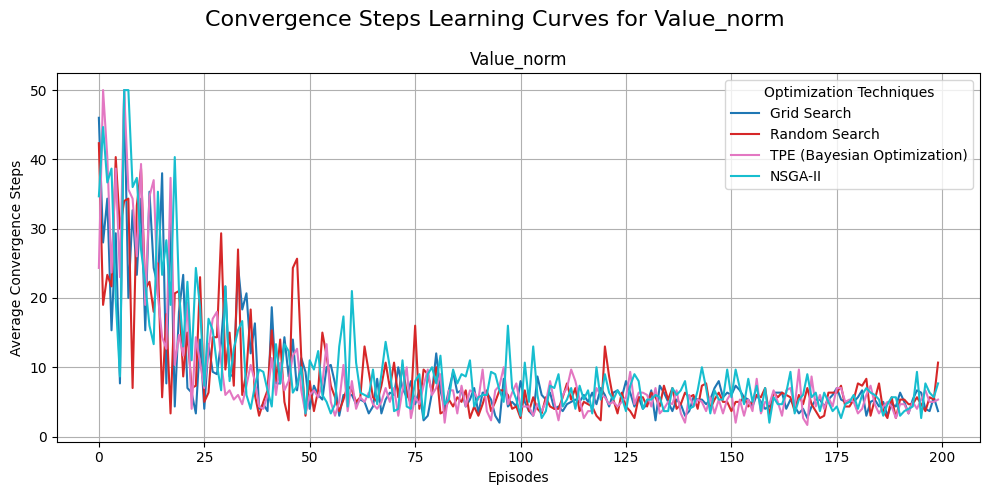

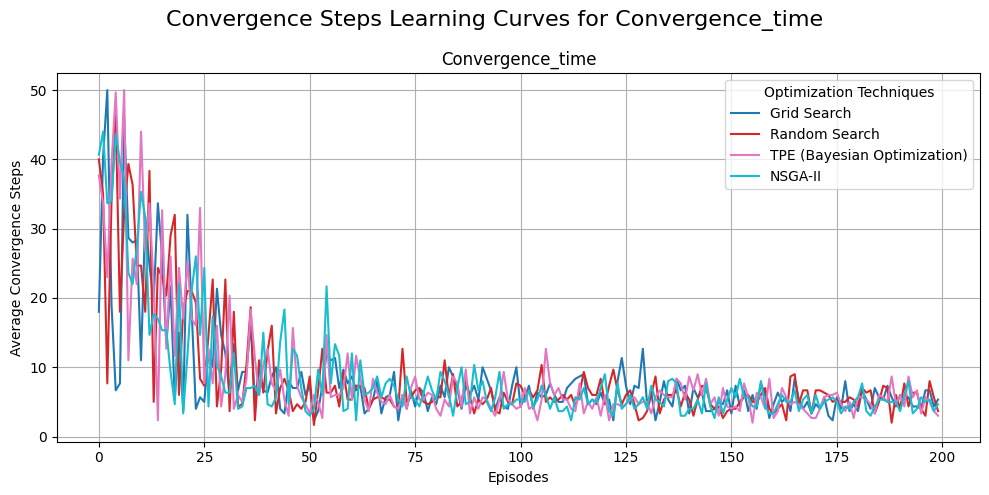

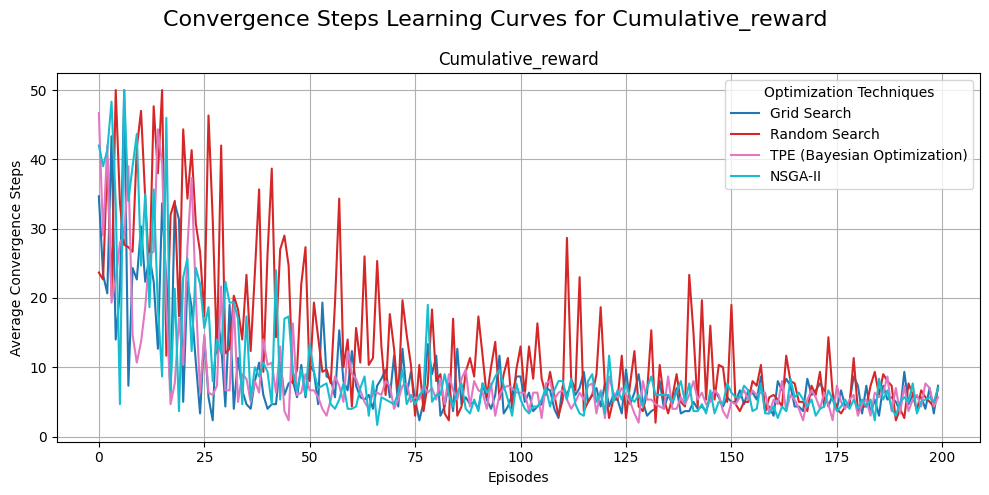

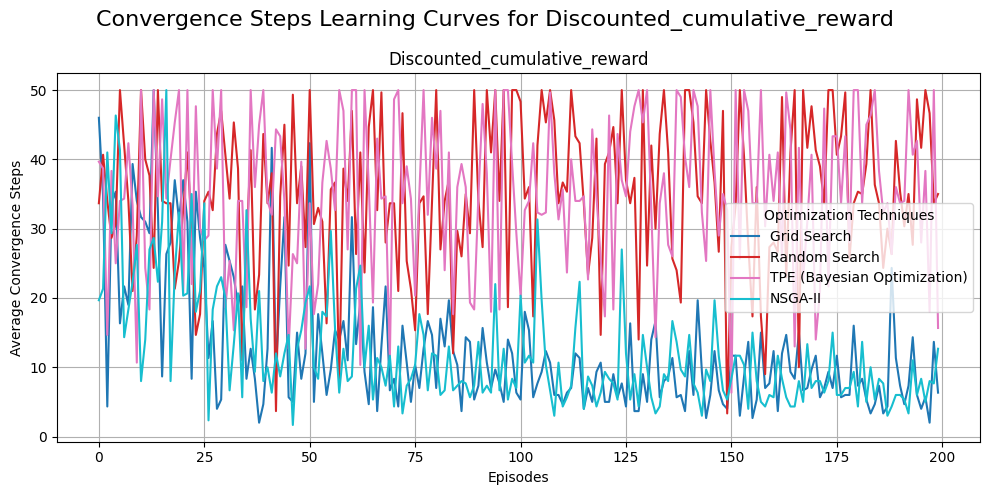

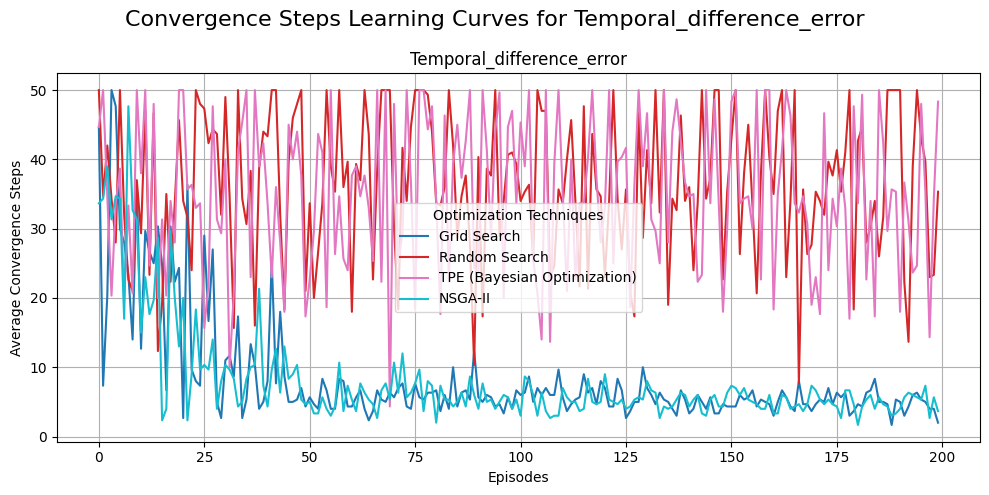

In [117]:
%matplotlib inline
plot_metric_per_criterion(criteria, results, n_runs, env, AC_PARAMS, "Convergence Steps", compute_convergence_steps)


### Mean Values Learing Curves

/tmp/ipykernel_128258/3896110873.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(SAMPLERS))  # Utilise une palette de 10 couleurs


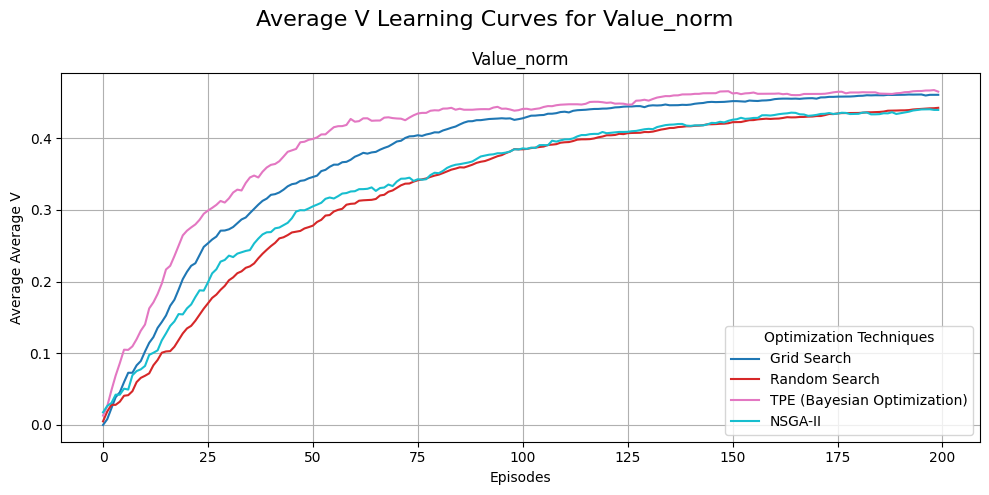

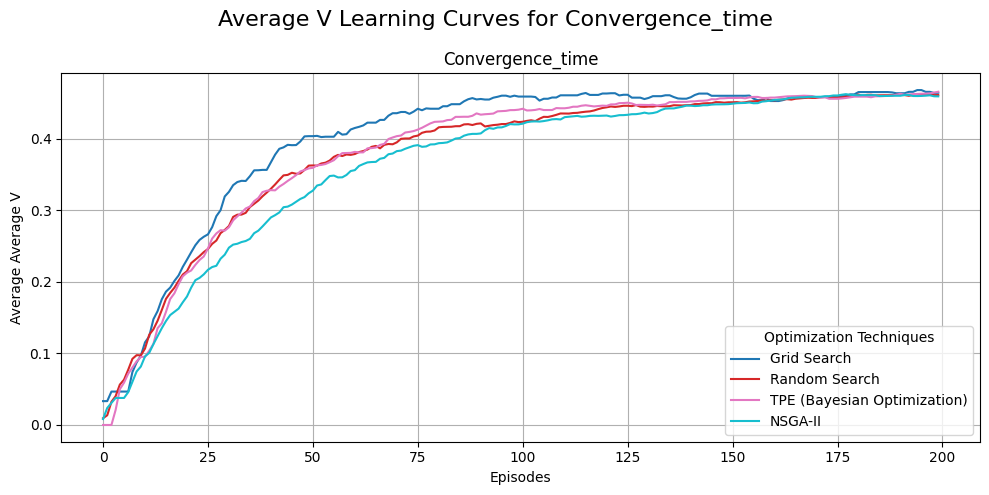

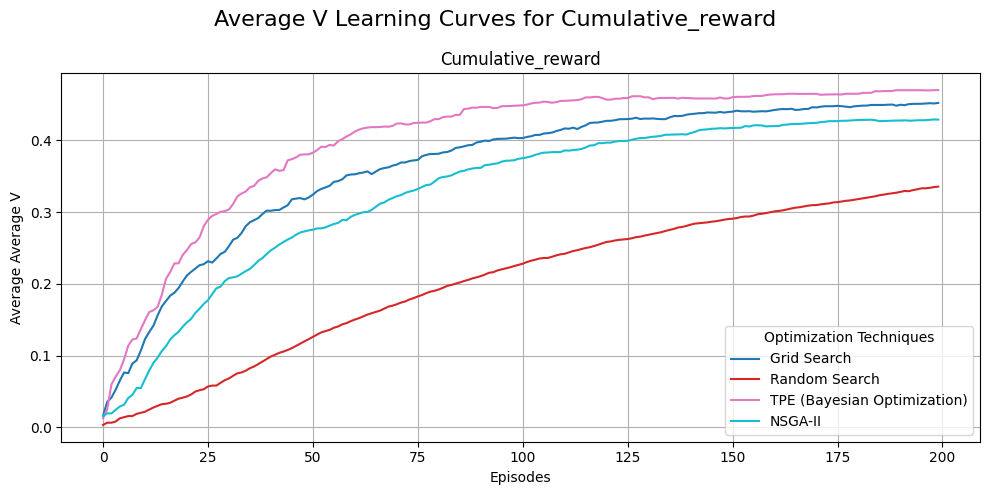

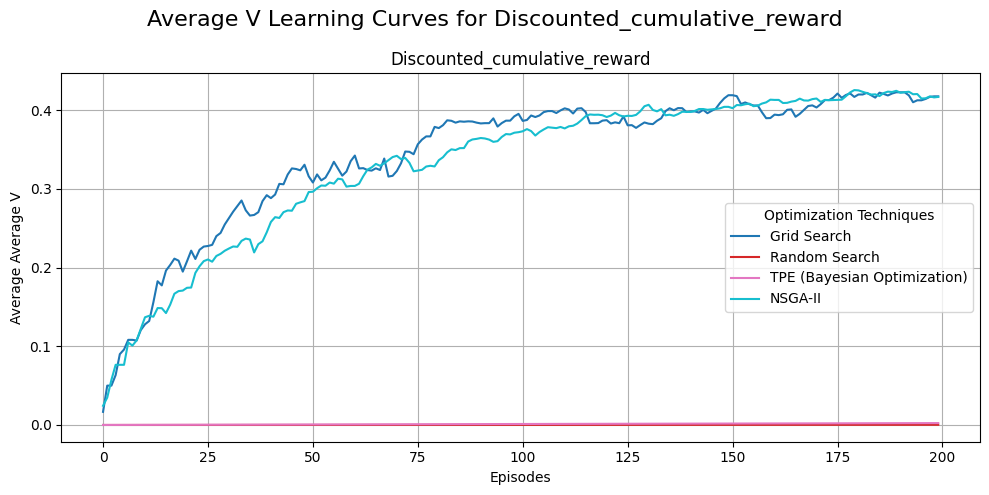

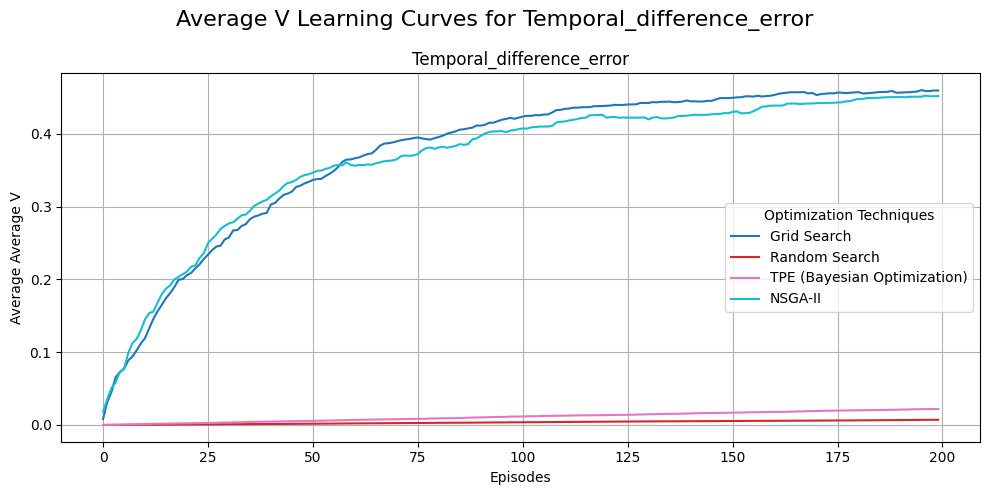

In [118]:
plot_metric_per_criterion(criteria, results, n_runs, env, AC_PARAMS, "Average V", compute_avg_values)


### Rewards Learning Curves

/tmp/ipykernel_128258/3896110873.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(SAMPLERS))  # Utilise une palette de 10 couleurs


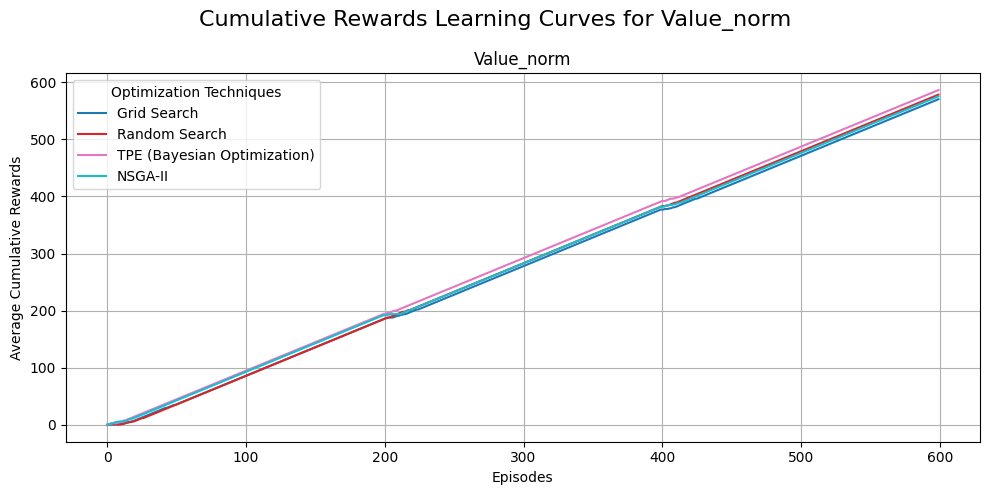

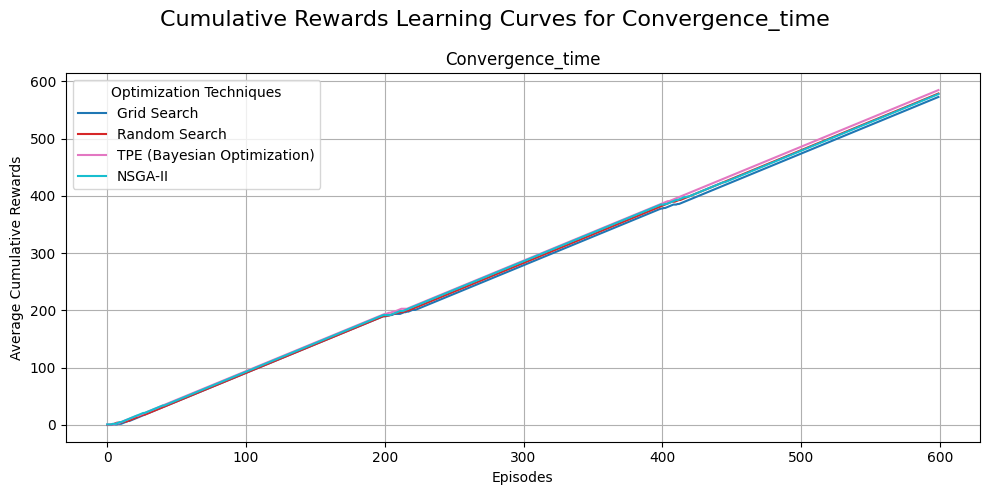

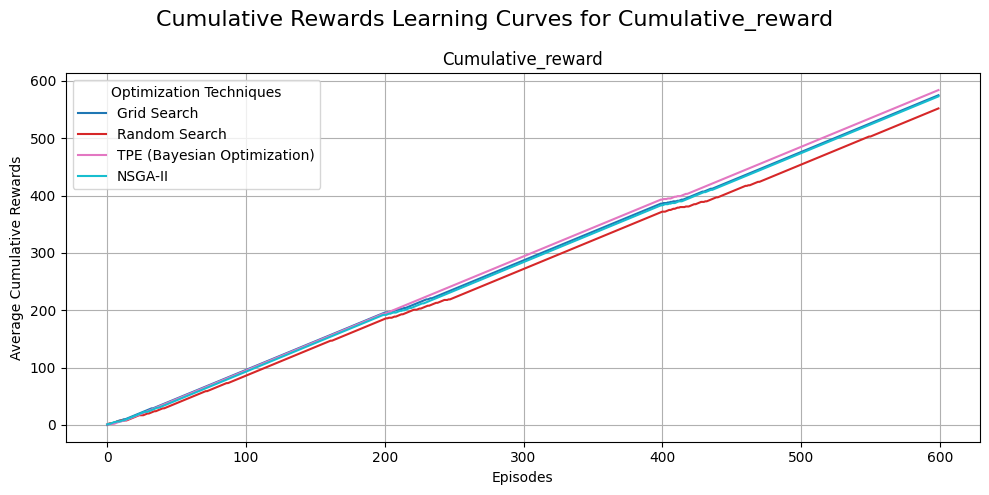

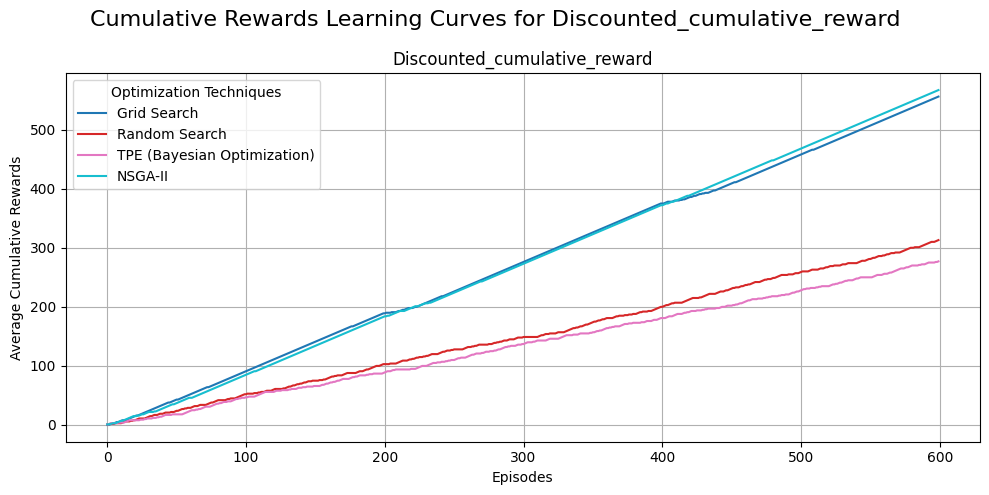

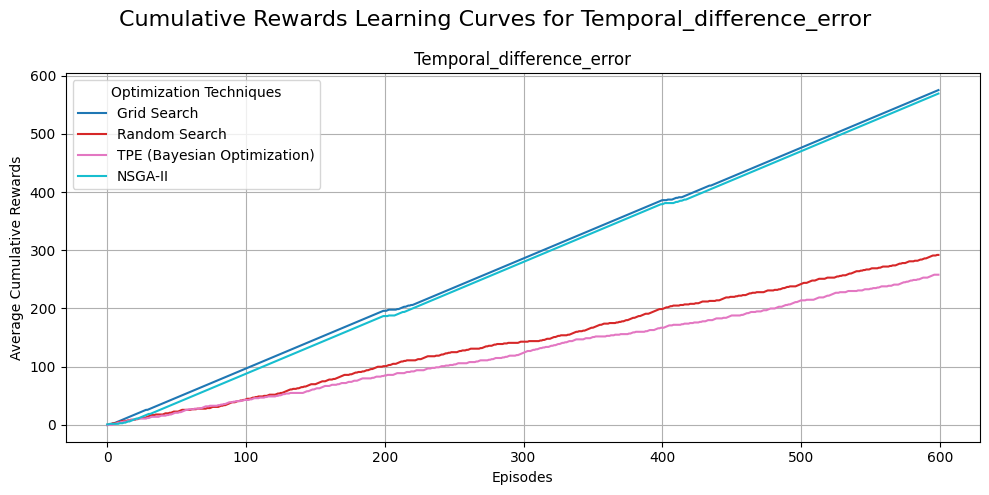

In [119]:
plot_metric_per_criterion(criteria, results, n_runs, env, AC_PARAMS, "Cumulative Rewards", compute_cumulative_rewards)


/tmp/ipykernel_128258/3896110873.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(SAMPLERS))  # Utilise une palette de 10 couleurs


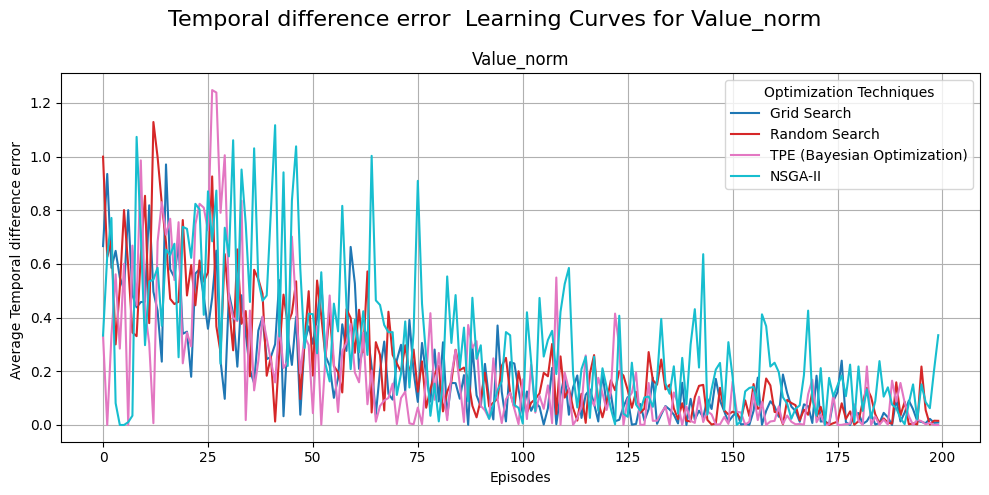

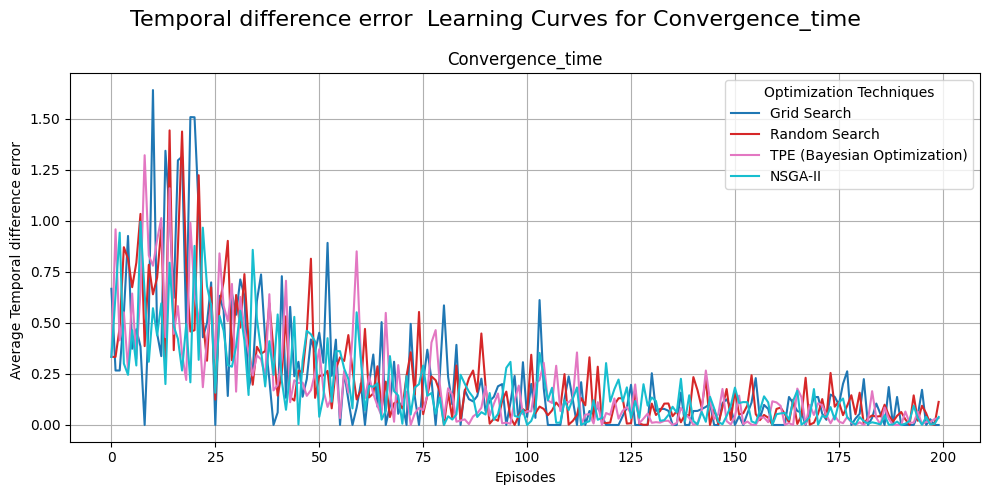

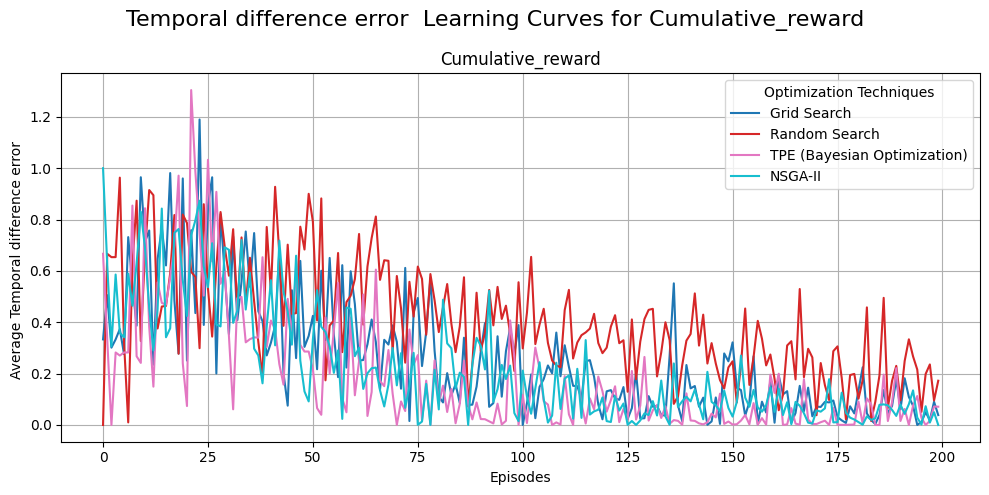

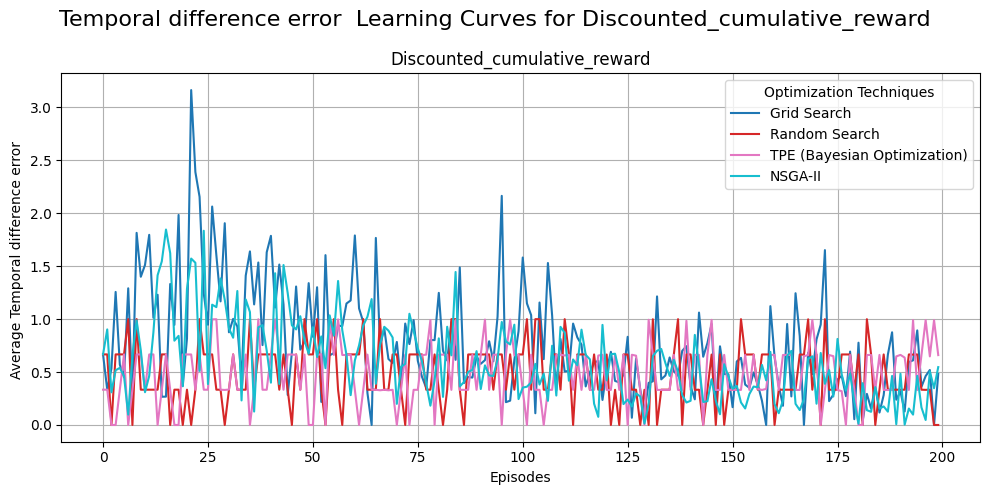

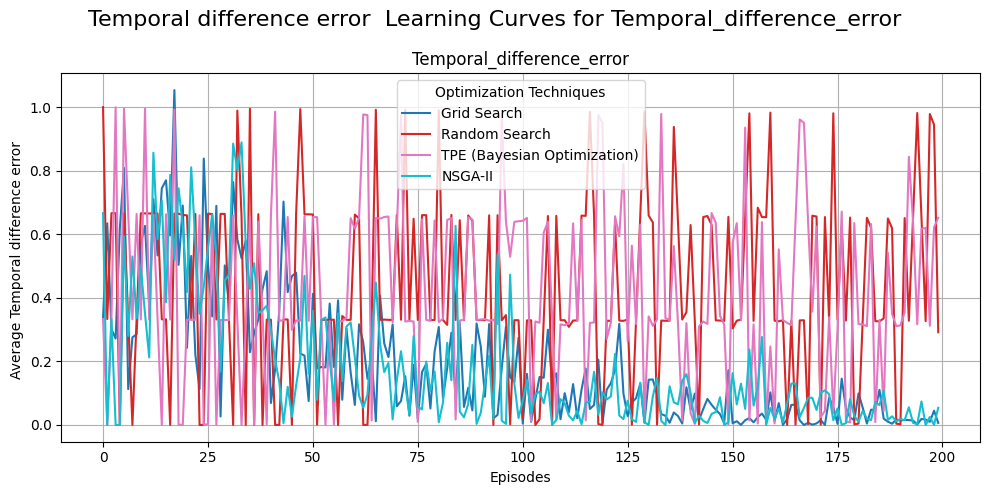

In [120]:
plot_metric_per_criterion(criteria, results, n_runs, env, AC_PARAMS, "Temporal difference error ", compute_deltas)


## The heat maps

### Value norms

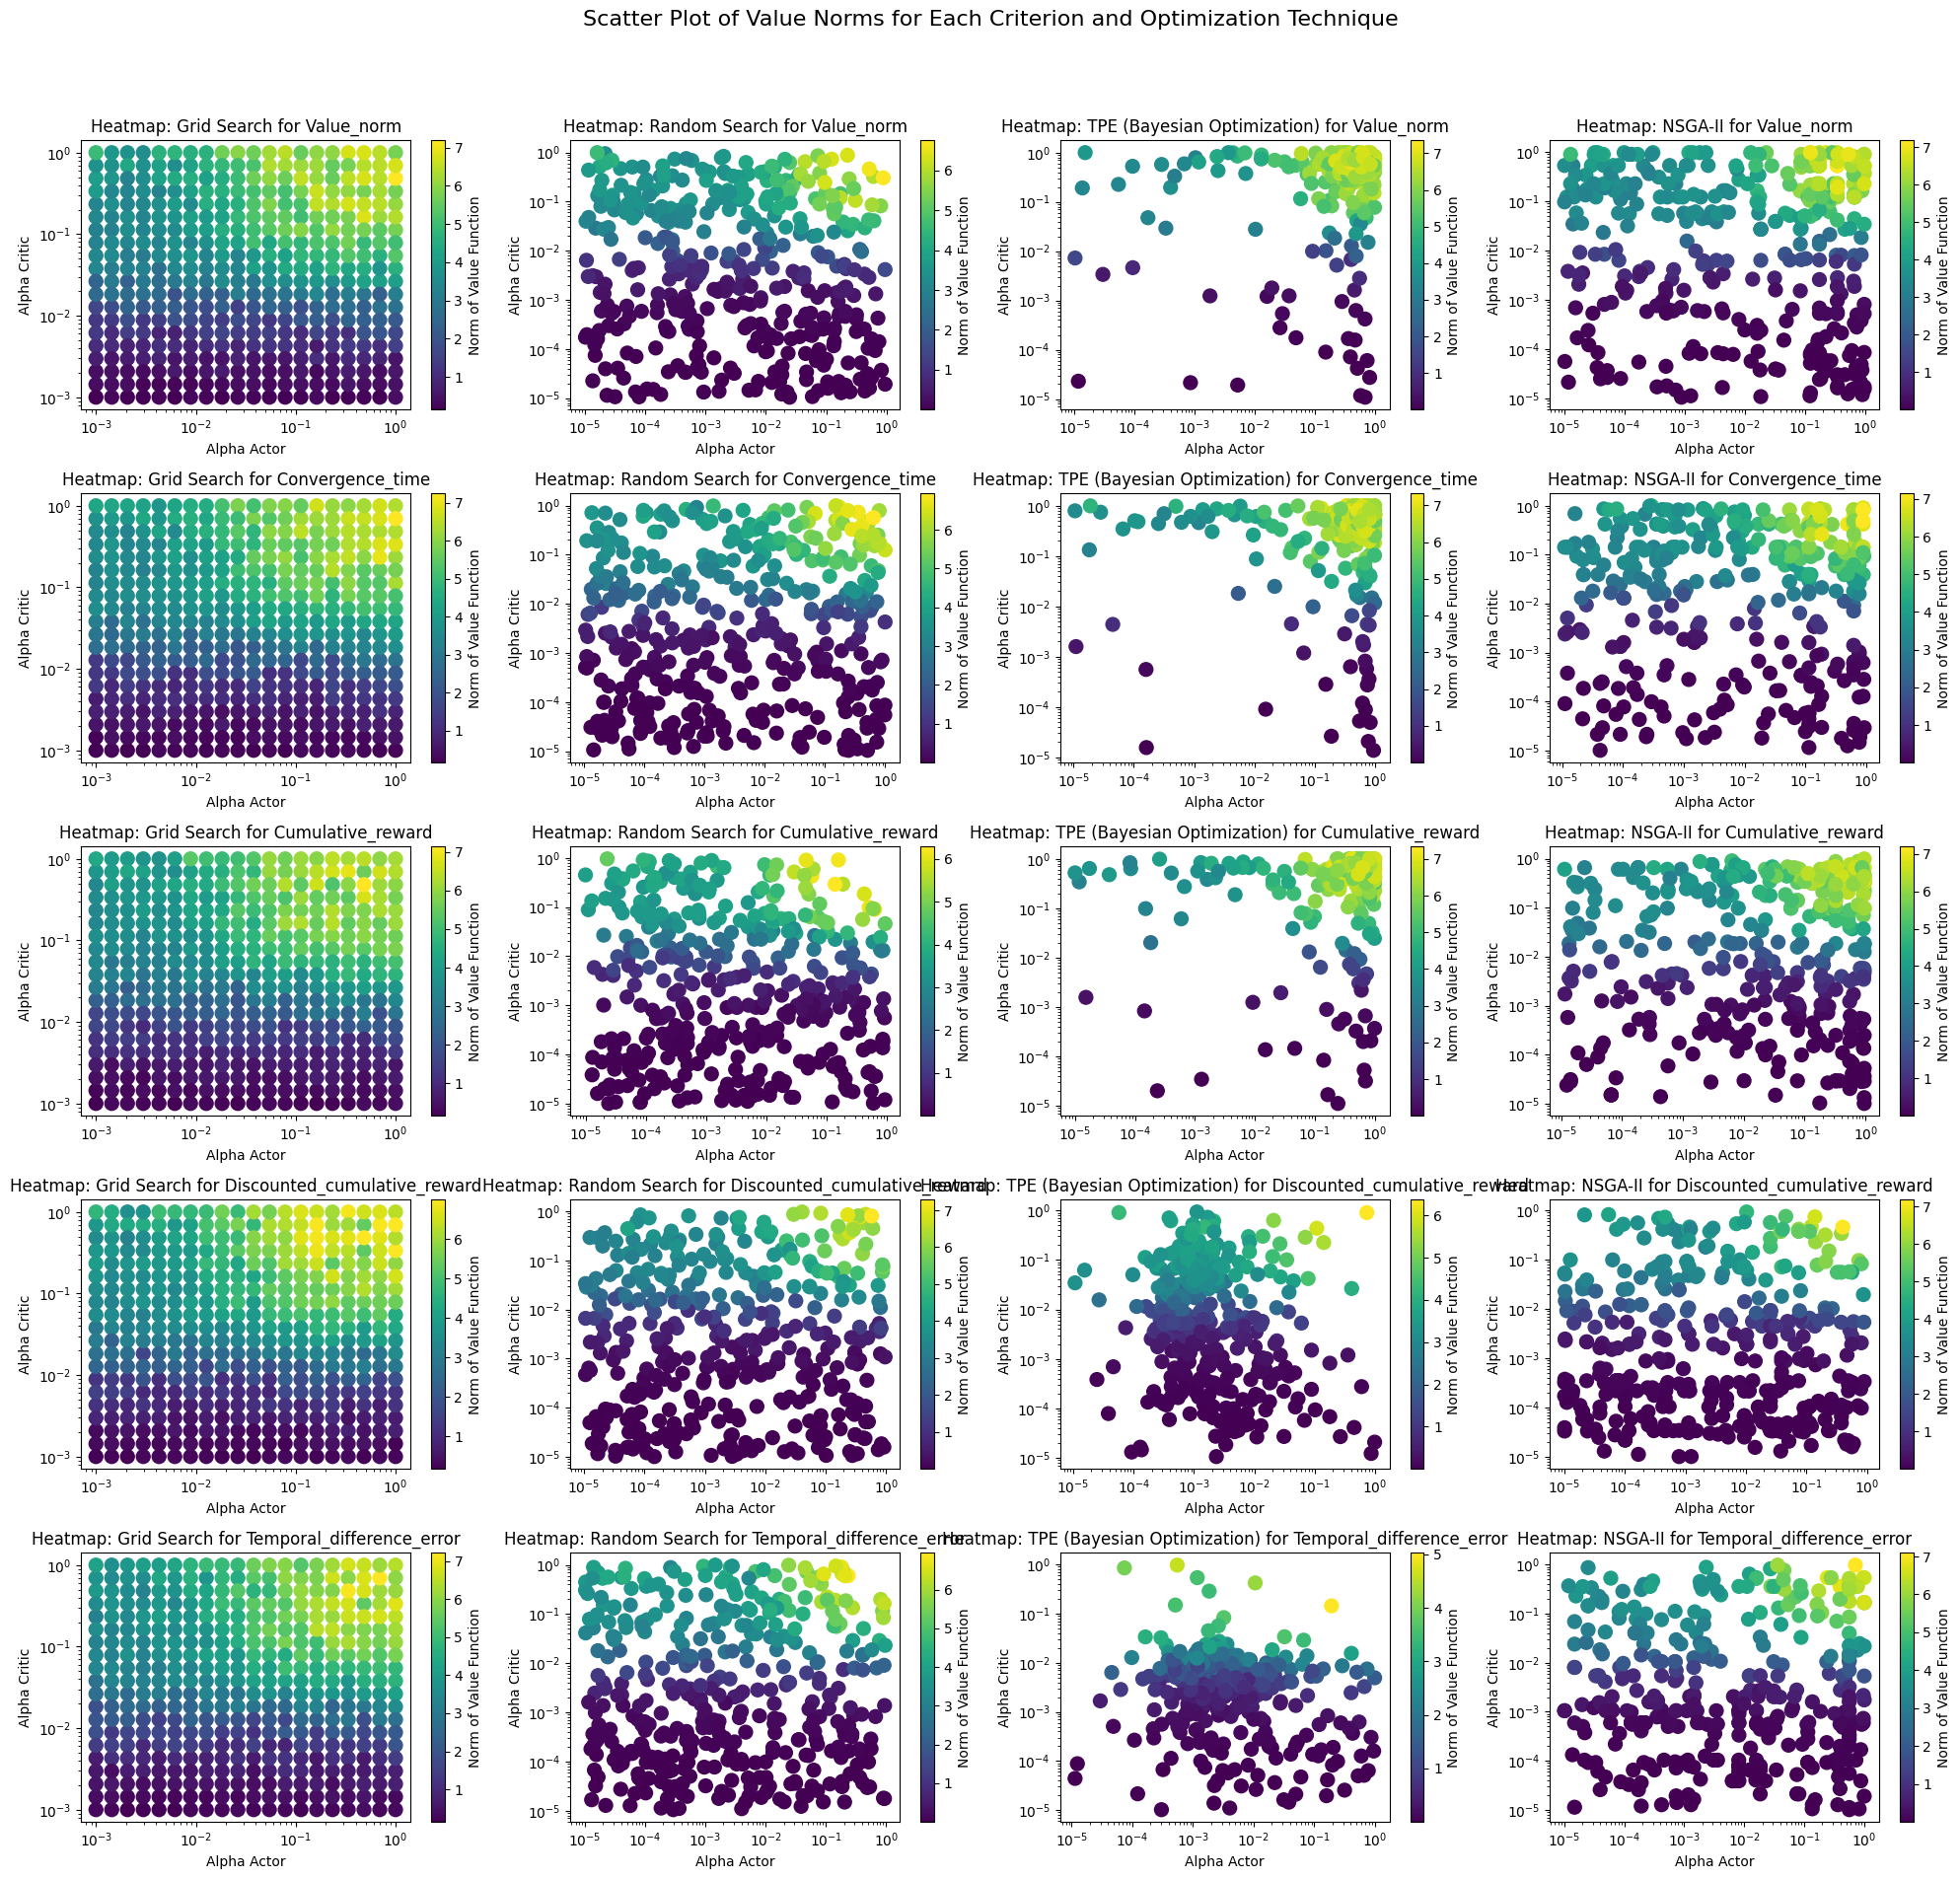

In [121]:
# Number of rows and columns for the grid of scatter plots
n_rows = len(criteria)  # Each row corresponds to a criterion
n_cols = len(SAMPLERS)  # Each column corresponds to an optimization technique

# Create a grid of subplots for the scatter plots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))
fig.suptitle("Scatter Plot of Value Norms for Each Criterion and Optimization Technique", fontsize=16)

# Iterate through each criterion (rows)
for i, criterion in enumerate(criteria):
    # Iterate through each sampler (columns)
    for j, sampler_name in enumerate(SAMPLERS.keys()):
        # Get the result key for the current criterion and sampler
        result_key = f"{criterion}_{sampler_name}"
        result = results.get(result_key)

        if result is None:
            continue  # Skip if there is no result for this combination

        # Extract the hyperparameter values and corresponding value norms
        alpha_actor_vals = [params[0] for params in result['all_params']]
        alpha_critic_vals = [params[1] for params in result['all_params']]
        value_norms = result['value_norms']

        # Select the correct subplot (axs is a grid)
        ax = axs[i, j]

        # Create the scatter plot
        scatter = ax.scatter(alpha_actor_vals, alpha_critic_vals, c=value_norms, cmap='viridis', s=100)

        # Set logarithmic scale for both axes
        ax.set_xscale('log')
        ax.set_yscale('log')

        # Add labels and titles
        ax.set_xlabel("Alpha Actor")
        ax.set_ylabel("Alpha Critic")
        ax.set_title(f"Heatmap: {sampler_name} for {criterion.capitalize()}")

        # Add a colorbar for each plot to represent the value norms
        fig.colorbar(scatter, ax=ax, label='Norm of Value Function')

# Adjust layout to ensure the plots are spaced properly
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plot
plt.show()

### The Cumulative Rewards

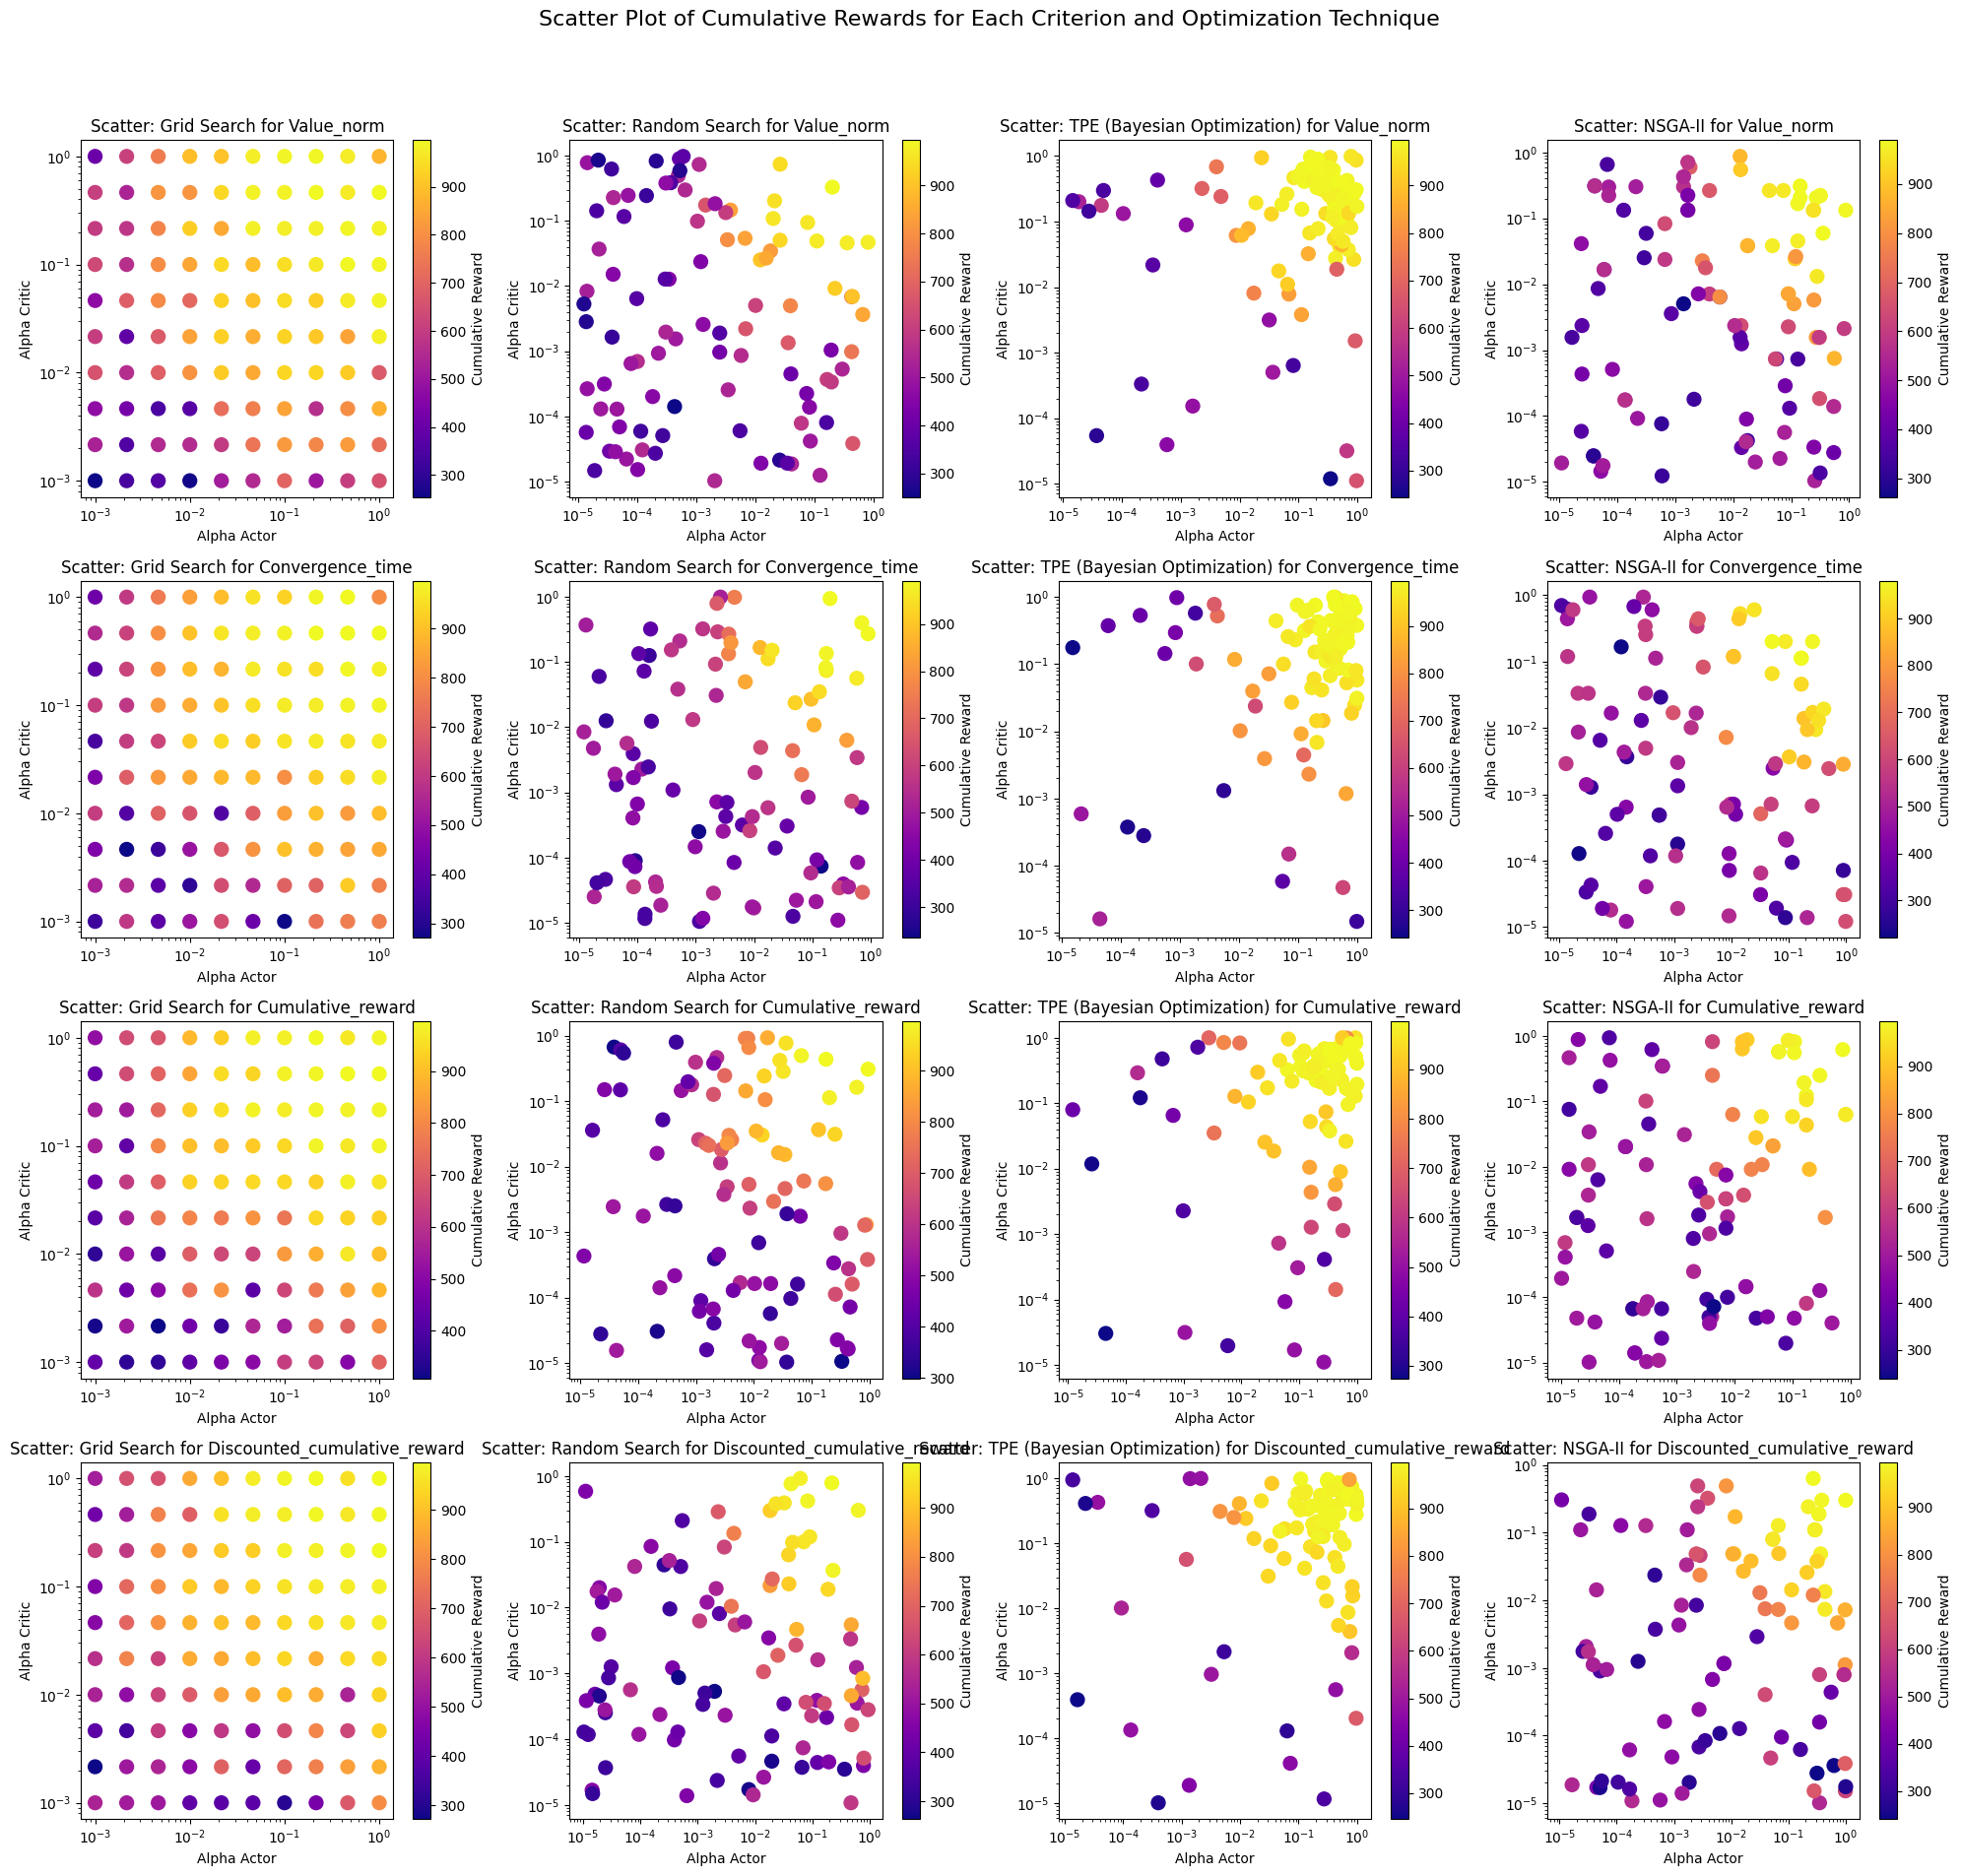

In [95]:
# Number of rows and columns for the grid of scatter plots
n_rows = len(criteria)  # Each row corresponds to a criterion
n_cols = len(SAMPLERS)  # Each column corresponds to an optimization technique

# Create a grid of subplots for the scatter plots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))
fig.suptitle("Scatter Plot of Cumulative Rewards for Each Criterion and Optimization Technique", fontsize=16)

# Iterate through each criterion (rows)
for i, criterion in enumerate(criteria):
    # Iterate through each sampler (columns)
    for j, sampler_name in enumerate(SAMPLERS.keys()):
        # Get the result key for the current criterion and sampler
        result_key = f"{criterion}_{sampler_name}"
        result = results.get(result_key)

        if result is None:
            continue  # Skip if there is no result for this combination

        # Extract the hyperparameter values and corresponding cumulative rewards
        alpha_actor_vals = [params[0] for params in result['all_params']]
        alpha_critic_vals = [params[1] for params in result['all_params']]
        cumulative_rewards = result['cumulative_rewards']

        # Select the correct subplot (axs is a grid)
        ax = axs[i, j]

        # Create the scatter plot for cumulative rewards
        scatter = ax.scatter(alpha_actor_vals, alpha_critic_vals, c=cumulative_rewards, cmap='plasma', s=100)

        # Set logarithmic scale for both axes
        ax.set_xscale('log')
        ax.set_yscale('log')

        # Add labels and titles
        ax.set_xlabel("Alpha Actor")
        ax.set_ylabel("Alpha Critic")
        ax.set_title(f"Scatter: {sampler_name} for {criterion.capitalize()}")

        # Add a colorbar for each plot to represent the cumulative rewards
        fig.colorbar(scatter, ax=ax, label='Cumulative Reward')

# Adjust layout to ensure the plots are spaced properly
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plot
plt.show()


# Step 3: Statistical tests

# Tests

## Exercise 3

As hyper-parameters, you will use:

- naive tuning, that is a pair (0.5, 0.5) for the actor and critic learning rates,
- the best hyper-parameters you found with the different tuning algorithms you used before.

### 1. For each set of hyper-parameters, collect a large dataset of learning curves.

We suggest using 150 training episodes.

### 2. Perform statistical comparisons

- Take two datasets of learning curves obtained with the hyper-parameters sets that you found with different tuning algorithms.
- Use the ``` perform_test(...)``` function to compare each possible pair of sets.

You should obtain an image for each pair you have tried.
In this image, black dots signal the time step where there is a statistically significant difference between two learning curves.

 ### 3. Conclude.

# Lab report

Your report should contain:
- your source code (probably this notebook), do not forget to put your names on top of the notebook,
- in a separate pdf file with your names in the name of the file:
    + a detailed enough description of the choices you have made: the parameters you have set, the libraries you have used, etc.,
    + the heatmaps obtained using the hyper-parameters tuning algorithms that you have used,
    + the figures resulting from performing Welch's T-test using the best hyper-parameters from the above approaches,
    + your conclusion from these experiments.

Beyond the elements required in this report, any additional studies will be rewarded.
For instance, you can try using a Q-function as critic, using random search as hyper-parameters tuning algorithm,
using more challenging environments, etc..